In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [10]:
data = pd.read_csv("daily_forex_rates.csv")
data

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,347.341553,2024-05-11
1,GHS,EUR,Ghanaian Cedi,15.101015,2024-05-11
2,HRK,EUR,Croatian Kuna,7.637382,2024-05-11
3,HNL,EUR,Honduran Lempira,26.659323,2024-05-11
4,HKD,EUR,Hong Kong Dollar,8.429786,2024-05-11
...,...,...,...,...,...
354853,CAD,EUR,Canadian Dollar,1.591300,2004-09-01
354854,AUD,EUR,Australian Dollar,1.729600,2004-08-31
354855,JPY,EUR,Japanese Yen,132.850000,2004-08-31
354856,CAD,EUR,Canadian Dollar,1.596700,2004-08-31


# EDA

## Analyse et conversion de la structure du dataset

Dans cette section, nous allons afficher les statistiques générales du dataset et nettoyer les données si nécessaires. 

In [11]:
# Stats basiques
print("Nombre de lignes : {}".format(data.shape[0]))
print()

print("Display du dataset: ")
display(data.head())
print()

print("Basique stats: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Pourcentage de missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Nombre de lignes : 354858

Display du dataset: 


,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,347.341553,2024-05-11
1,GHS,EUR,Ghanaian Cedi,15.101015,2024-05-11
2,HRK,EUR,Croatian Kuna,7.637382,2024-05-11
3,HNL,EUR,Honduran Lempira,26.659323,2024-05-11
4,HKD,EUR,Hong Kong Dollar,8.429786,2024-05-11



Basique stats: 


,currency,base_currency,currency_name,exchange_rate,date
count,354858,354858,354662,3.548580e+05,354858
unique,172,1,169,NaN,5717
top,AUD,EUR,Australian Dollar,NaN,2024-05-11
freq,5195,354858,5195,NaN,171
mean,NaN,NaN,NaN,5.539011e+03,NaN
std,NaN,NaN,NaN,1.235109e+05,NaN
min,NaN,NaN,NaN,1.497045e-05,NaN
25%,NaN,NaN,NaN,2.505750e+00,NaN
50%,NaN,NaN,NaN,1.696692e+01,NaN
75%,NaN,NaN,NaN,1.471208e+02,NaN



Pourcentage de missing values: 


currency         0.000000
base_currency    0.000000
currency_name    0.055233
exchange_rate    0.000000
date             0.000000
dtype: float64

In [12]:
# Conversion de la colonne 'date' en format datetime
data['date'] = pd.to_datetime(data['date'])

# Vérification des doublons
duplicates = data.duplicated().sum()
print("Nombre de doublons : ", duplicates)

Nombre de doublons :  0


Nous pouvons remarquer que le dataset est très propre et qu'aucune transformation n'est réellement nécessaire.

## Exploration de la distribution et des tendances du dataset 

Nous allons explorer le dataset dans cette partie pour comprendre la distribution et les tendances de façon générales puis sur les devises les plus fréquentes.

### Distribution des taux de changes

Dans cette première étape, nous visualisons la distribution des taux de change en utilisant un histogramme. L'objectif est d'identifier la forme de la distribution et de détecter la présence éventuelle de biais ou d'asymétrie. 

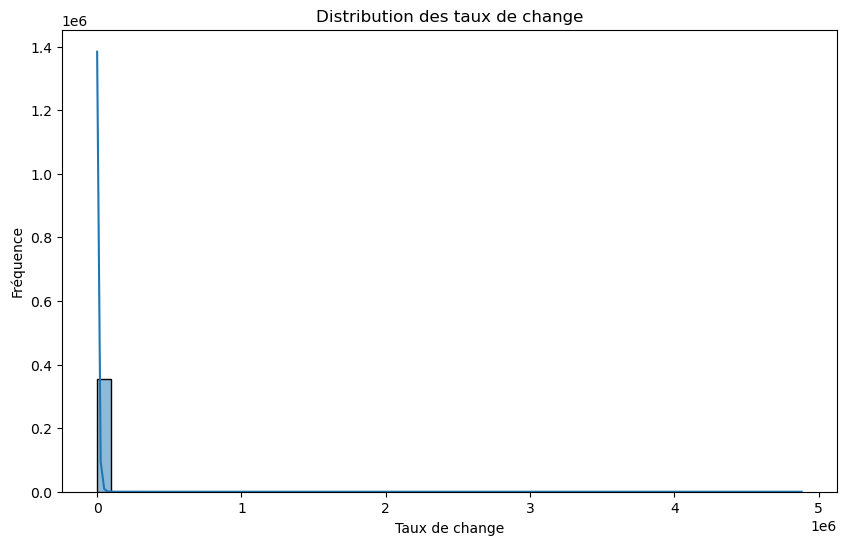

In [13]:
# Distribution de 'exchange_rate'
plt.figure(figsize=(10, 6))
sns.histplot(data['exchange_rate'], bins=50, kde=True)
plt.title('Distribution des taux de change')
plt.xlabel('Taux de change')
plt.ylabel('Fréquence')
plt.show()


La distribution des taux de change est fortement asymétrique, indiquant la présence de valeurs extrêmes. Cela peut nécessiter une transformation ou un traitement des outliers.

### Distribution des taux de change (transformation logarithmique)

Pour réduire l'asymétrie et normaliser la distribution des taux de change, nous appliquons une transformation logarithmique. En prenant le logarithme naturel des taux de change augmentés de 1, nous rendrons la distribution plus symétrique et plus adaptée pour nos analyses.

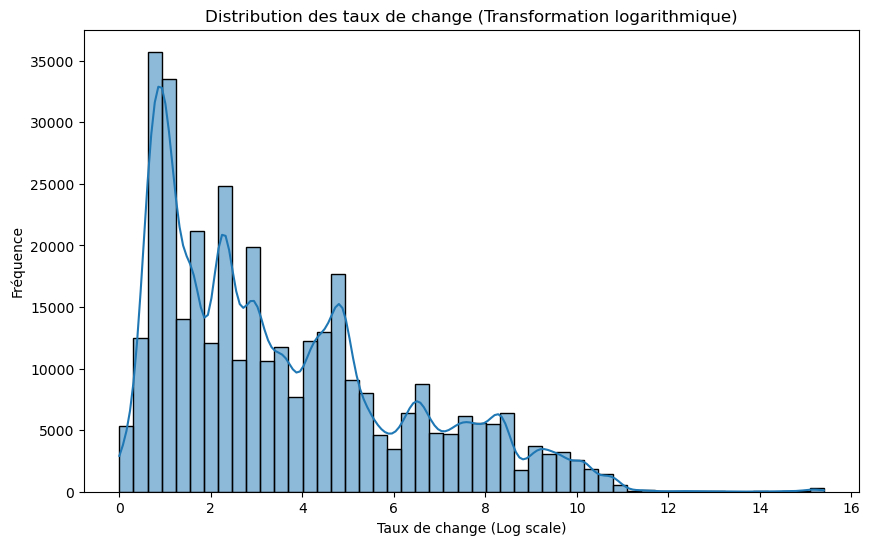

In [14]:
# Transformation logarithmique des taux de change pour réduires l'asymétrie des données
data['log_exchange_rate'] = np.log1p(data['exchange_rate'])

# Tracé des taux de change transformés
plt.figure(figsize=(10, 6))
sns.histplot(data['log_exchange_rate'], bins=50, kde=True)
plt.title('Distribution des taux de change (Transformation logarithmique)')
plt.xlabel('Taux de change (Log scale)')
plt.ylabel('Fréquence')
plt.show()

* Après la transformation logarithmique, la distribution des taux de change est beaucoup plus étalée et présente une forme plus normale par rapport à la distribution initiale.
* La distribution montre plusieurs pics, suggérant la présence de plusieurs sous-groupes ou clusters dans les données.
* La transformation logarithmique a réussi à réduire l'asymétrie initiale. La distribution est maintenant plus centrée autour de la médiane, avec une diminution de l'impact des valeurs extrêmes.
* La concentration des données autour des valeurs plus faibles de la transformation logarithmique indique que la plupart des taux de change, lorsqu'ils sont pris sous forme logarithmique, se situent dans une plage plus étroite.
* La transformation logarithmique a également aidé à réduire l'impact visuel des outliers. Dans la distribution initiale, les outliers étaient très dispersés. Maintenant, ils sont mieux intégrés dans la distribution globale.

### Identification et compréhension des outliers

Dans ce genre de dataset, il y a de grandes disparitées entre les différentes devises. Analyser les outliers pourraient permettre de procurer de précieuses informations sur la distribution et l'étendue générale des données. 

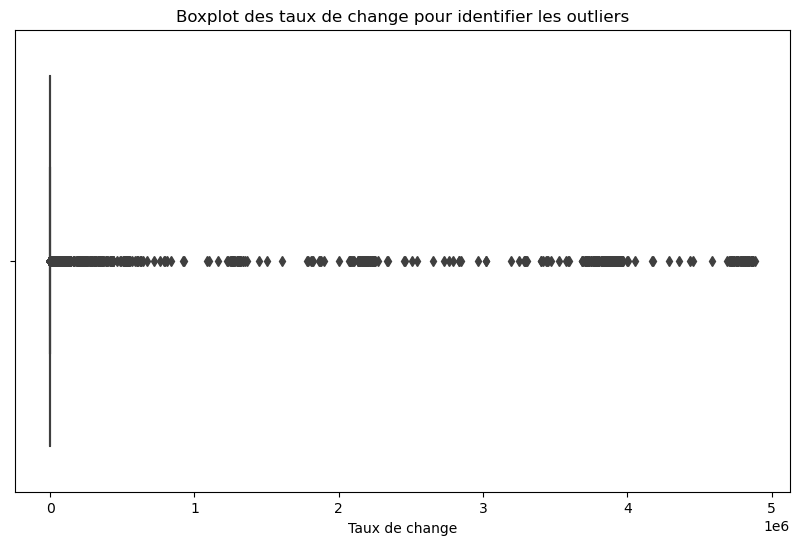

In [15]:
# Identification des outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['exchange_rate'])
plt.title('Boxplot des taux de change pour identifier les outliers')
plt.xlabel('Taux de change')
plt.show()

* Distribution des taux de change : La plupart des taux de change se situent dans une plage relativement étroite, près de zéro, comme le montre la boîte compacte à l'extrémité gauche du graphique.
* Présence d'outliers : Un grand nombre de points (outliers) sont dispersés sur l'axe des x, allant de 0 jusqu'à environ 5 millions. Ces outliers indiquent que certaines devises ont des taux de change extrêmement élevés par rapport à l'EUR, ce qui est cohérent avec des devises ayant une faible valeur par rapport à l'EUR.
* Étendue des données : La moustache supérieure s'étend jusqu'à une certaine valeur, après laquelle les points sont considérés comme des outliers. Cela montre que la majorité des données se concentrent dans une plage étroite, avec quelques valeurs très élevées.

### Top 10 des devises les plus fréquentes et sanity check sur la devise de base.

Dans cette section, nous analysons la fréquence d'apparition des différentes devises dans notre jeu de données. Cela nous permettra d'identifier les devises dominantes dans le dataset, ce qui peut être important pour comprendre les tendances et les dynamiques du marché des changes.

Nous réalisons également un sanity check sur la fréquence des devises de bases pour être certain qu'il s'agit bien de l'euro uniquement.

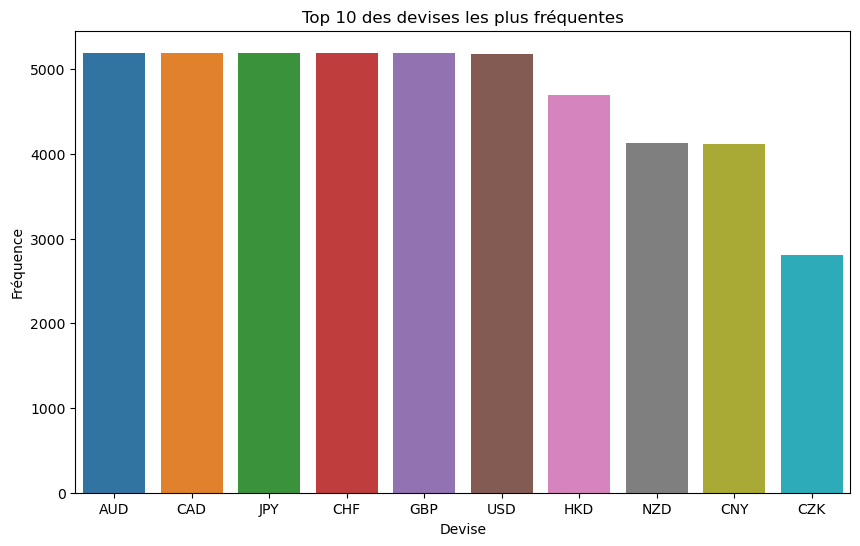

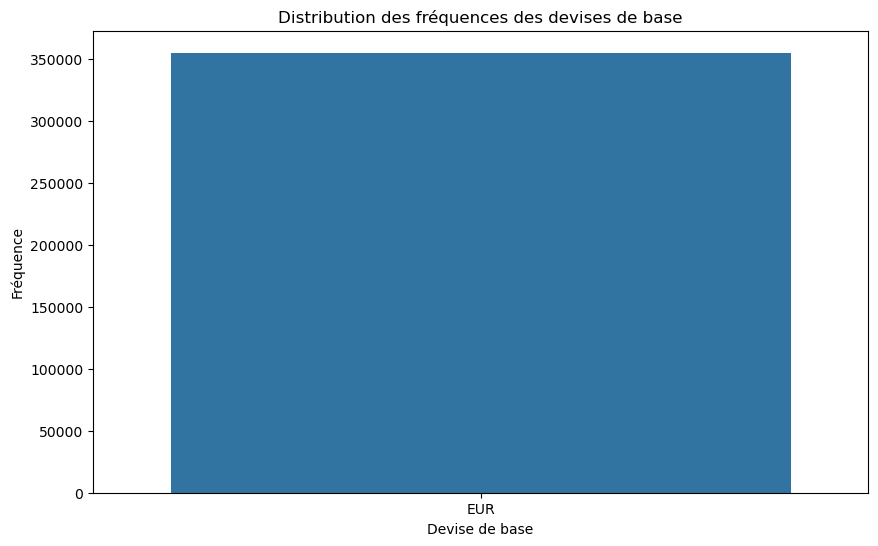

In [16]:
# Distribution des fréquences pour 'currency'
currency_freq = data['currency'].value_counts().head(10)

# Distribution des fréquences pour 'base_currency'
base_currency_freq = data['base_currency'].value_counts()

# Affichage des fréquences pour 'currency'
plt.figure(figsize=(10, 6))
sns.barplot(x=currency_freq.index, y=currency_freq.values)
plt.title('Top 10 des devises les plus fréquentes')
plt.xlabel('Devise')
plt.ylabel('Fréquence')
plt.show()

# Affichage des fréquences pour 'base_currency'
plt.figure(figsize=(10, 6))
sns.barplot(x=base_currency_freq.index, y=base_currency_freq.values)
plt.title('Distribution des fréquences des devises de base')
plt.xlabel('Devise de base')
plt.ylabel('Fréquence')
plt.show()


Les devises les plus fréquentes dans le dataset incluent AUD, CAD, JPY, etc., tandis que toutes les transactions ont bien l'EUR comme monnaie de base.

### Analyse des tendances des top devises. 

Nous avons choisi cinq devises principales (USD, GBP, JPY, AUD, CAD) défini auparavant afin d'analyser leurs tendances de taux de change. En filtrant le dataset pour ces devises, nous traçons leurs taux de change au fil du temps sur une échelle logarithmique, ce qui aide à visualiser les variations sur une longue période.

Ensuite nous calculons la moyenne mobile sur 30 jours (qui est une moyenne de base) pour le taux de change USD/EUR. Cette méthode permet de lisser les fluctuations quotidiennes et met en évidence les tendances à long terme, nous offrant une perspective plus claire sur les mouvements du marché.



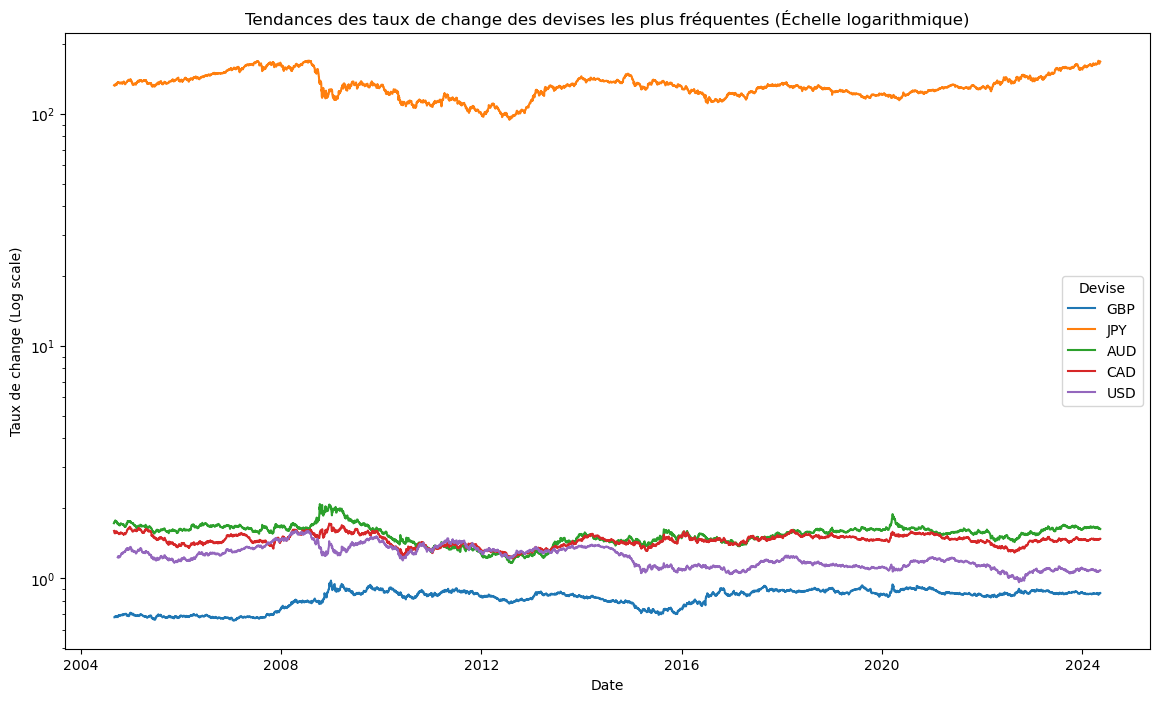

In [17]:
# Sélection de quelques devises pour l'analyse des tendances
selected_currencies = ['USD', 'GBP', 'JPY', 'AUD', 'CAD']

# Filtrage du dataset pour les devises les plus fréquentes
df_selected = data[data['currency'].isin(selected_currencies)]

# Tracé des taux de change au fil du temps pour les devises les plus fréquentes avec une échelle logarithmique
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_selected, x='date', y='exchange_rate', hue='currency')
plt.yscale('log')
plt.title('Tendances des taux de change des devises les plus fréquentes (Échelle logarithmique)')
plt.xlabel('Date')
plt.ylabel('Taux de change (Log scale)')
plt.legend(title='Devise')
plt.show()


* **Stabilité du JPY** : La stabilité relative et la valeur élevée du JPY suggèrent une économie japonaise résiliente, moins affectée par les crises financières globales. Cela peut être dû à des politiques monétaires strictes et à une économie moins volatile.

* **Fluctuations du GBP et de l'AUD** : Les fluctuations significatives du GBP et de l'AUD, notamment autour de 2008, pourraient indiquer une sensibilité accrue aux événements économiques mondiaux, comme la crise financière, ou à des politiques économiques nationales.

* **USD et CAD stables avec variations** : La relative stabilité du USD et du CAD, avec quelques variations notables, pourrait refléter des économies diversifiées et robustes, mais sensibles aux changements dans les politiques économiques et aux conditions du marché mondial.

#### **Hypothèses**

* **Influence des politiques monétaires** : Les variations observées peuvent être hypothétiquement liées aux politiques monétaires spécifiques de chaque pays, comme les taux d'intérêt et les interventions sur le marché des changes.

* **Impact des événements économiques globaux** : Les fluctuations majeures coïncident souvent avec des crises économiques mondiales ou des événements significatifs, suggérant une forte corrélation entre les taux de change et ces événements.

* **Diversification économique** : Les devises avec moins de fluctuations pourraient appartenir à des économies plus diversifiées, mieux à même d'absorber les chocs économiques.

Ces conclusions et hypothèses fournissent des points de départ pour des analyses plus approfondies sur les facteurs influençant les taux de change des devises principales.

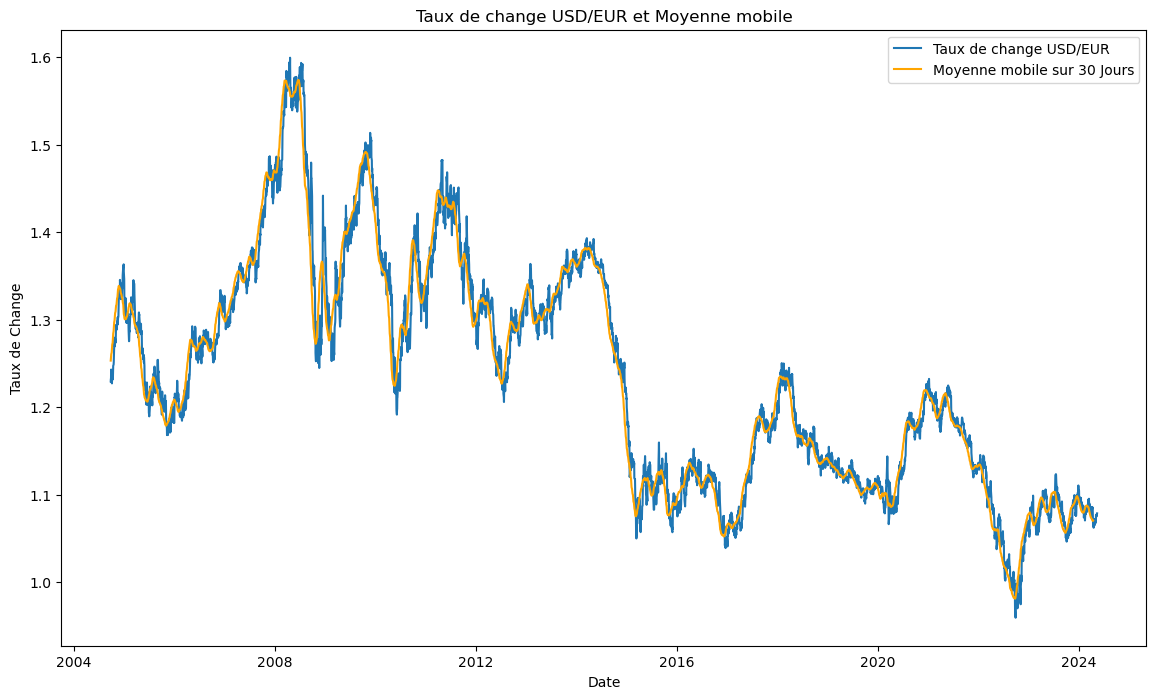

In [18]:
# Calcul et affichage des moyennes mobiles pour une devise sélectionnée (ex : USD)
df_usd = data[data['currency'] == 'USD'].set_index('date')
df_usd['rolling_mean'] = df_usd['exchange_rate'].rolling(window=30).mean()

plt.figure(figsize=(14, 8))
plt.plot(df_usd['exchange_rate'], label='Taux de change USD/EUR')
plt.plot(df_usd['rolling_mean'], label='Moyenne mobile sur 30 Jours', color='orange')
plt.title('Taux de change USD/EUR et Moyenne mobile')
plt.xlabel('Date')
plt.ylabel('Taux de Change')
plt.legend()
plt.show()

* **Crises économiques** : Les crises financières majeures, comme celles de 2008 et 2011-2012, ont un impact direct sur la confiance des investisseurs et sur les taux de change.

* **Politiques monétaires** : Les décisions de la Réserve fédérale américaine, telles que l'ajustement des taux d'intérêt et les programmes de quantitative easing, influencent significativement la valeur du dollar par rapport à l'euro.

* **Événements géopolitiques et politiques** : Les tensions commerciales, les élections américaines et les changements de politique intérieure (par exemple, les politiques fiscales et les réformes économiques) créent des incertitudes qui affectent les taux de change.

En résumé, cette exemple sur le taux de change USD/EUR nous démontre que celui-ci est fortement influencé par les crises économiques, les politiques monétaires et les événements géopolitiques majeurs. Les variations observées reflètent la réaction des marchés aux conditions économiques des États-Unis et de l'Europe sur la période étudiée.

## Analyse des devises par rendements 

### Top 10 des devises avec les meilleurs rendements depuis 2004

L'analyse de cette section permet d'identifier les devises les plus performantes par rapport à l'Euro en termes de rendement annuel et de volatilité. En pivotant les données et calculant les rendements logarithmiques, nous obtenons des insights sur la performance historique des devises. Le classement et la visualisation des devises les plus performantes aident à évaluer les risques et les rendements potentiels, facilitant ainsi des décisions d'investissement plus éclairées pour des rendements à fort potentuels.

In [19]:
# Pivot des données pour obtenir une matrice de taux de change par date
df_pivot = data.pivot(index='date', columns='currency', values='exchange_rate')

# Calcul des rendements log pour chaque devise
df_log_returns = np.log(df_pivot / df_pivot.shift(1))

# Statistiques de performance
mean_returns = df_log_returns.mean() * 252  # Rendements annuels moyens
volatilities = df_log_returns.std() * np.sqrt(252)  # Volatilités annuelles

# Création d'un DataFrame pour les performances
performance = pd.DataFrame({'Rendement annuel moyen': mean_returns, 'Volatilité annuelle': volatilities})

# Tri des devises par rendement annuel moyen
performance_sorted = performance.sort_values(by='Rendement annuel moyen', ascending=False)

# Sélection des 10 meilleures devises en termes de rendement
top_10_performance = performance_sorted.head(10)

# Affichage des meilleures devises en termes de rendement
print("Top 10 des devises avec les meilleurs rendements pour l'Euro :")
print(top_10_performance)

Top 10 des devises avec les meilleurs rendements pour l'Euro :
          Rendement annuel moyen  Volatilité annuelle
currency                                             
VEF                     2.442781             3.997156
NGN                     0.799547             0.533698
LBP                     0.479575             1.024048
ARS                     0.398976             0.322746
ZMW                     0.305801             0.159368
SLE                     0.241574             0.233922
TRY                     0.227709             0.174927
BYR                     0.220848             0.176272
GHS                     0.183851             0.196337
MRO                     0.158604             0.072416


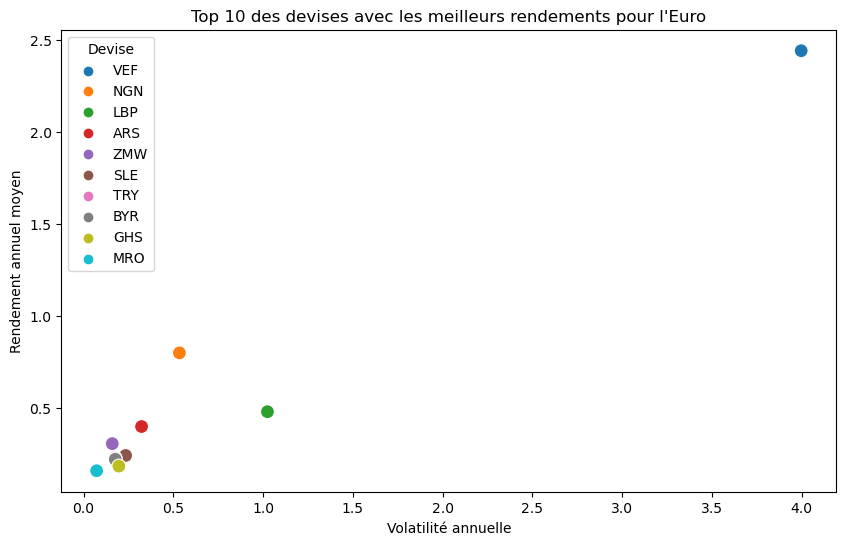

In [20]:
# Visualisation des performances
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_10_performance, x='Volatilité annuelle', y='Rendement annuel moyen', hue=top_10_performance.index, s=100)
plt.title("Top 10 des devises avec les meilleurs rendements pour l'Euro")
plt.xlabel('Volatilité annuelle')
plt.ylabel('Rendement annuel moyen')
plt.legend(title='Devise')
plt.show()

Nous pouvons constater ici les données les plus performantes en terme de rendements/volatilité depuis 2004. Ces informations nous serviront pour les croisées sur des periodes plus actuels en analysant les prochaines paires sur un intervale de 5 ans.

### Top 5 des devises avec les meilleurs rendements sur 1-3-5 ans.

Nous affichons les paires ayants eu les meilleurs rendements sur 1-3-5 ans pour identifier les devises aux potentielles les plus intéressants qu'elles ont pu avoir sur du cours et long terme. Nous selectionnerons ensuite 3 devises pour des analyses approfondies.

In [21]:
# Défini les dates de fin et les périodes à analyser
end_date = data['date'].max()
periods = {'1 an': 1, '3 ans': 3, '5 ans': 5}

# Fonction pour calculer les performances sur une période donnée
def calculate_performance(df, period):
    start_date = end_date - pd.DateOffset(years=period)
    df_period = df[df['date'] >= start_date]
    df_pivot = df_period.pivot(index='date', columns='currency', values='exchange_rate')
    df_log_returns = np.log(df_pivot / df_pivot.shift(1))
    mean_returns = df_log_returns.mean() * 252
    volatilities = df_log_returns.std() * np.sqrt(252)
    performance = pd.DataFrame({'Rendement Annuel Moyen': mean_returns, 'Volatilité Annuelle': volatilities})
    return performance.sort_values(by='Rendement Annuel Moyen', ascending=False).head(5)

# Calcul les performances pour chaque période
top_performances = {period_name: calculate_performance(data, years) for period_name, years in periods.items()}

Top 5 des devises avec les meilleurs rendements pour l'Euro sur 1 an :
          Rendement Annuel Moyen  Volatilité Annuelle
currency                                             
LBP                     1.543962             1.671689
ARS                     0.903219             0.728794
NGN                     0.799547             0.533698
CLF                     0.578640             0.426426
MWK                     0.455782             0.459177




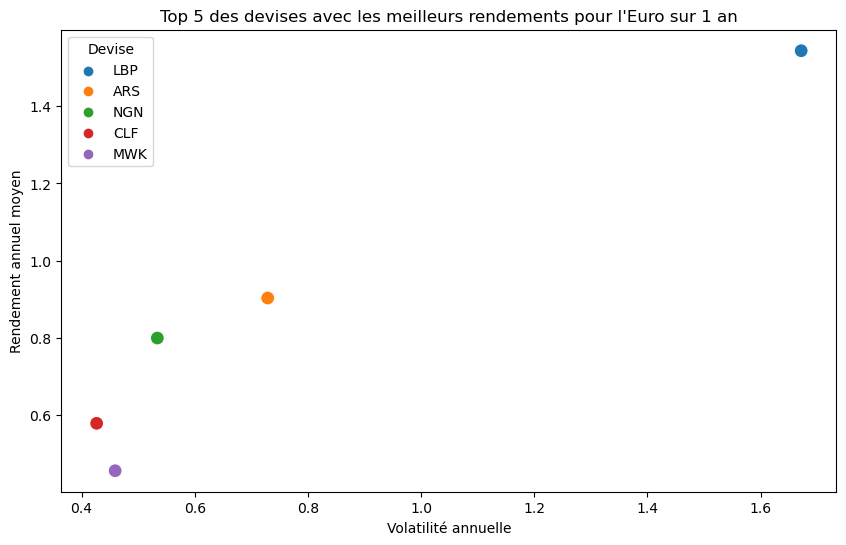

Top 5 des devises avec les meilleurs rendements pour l'Euro sur 3 ans :
          Rendement Annuel Moyen  Volatilité Annuelle
currency                                             
LBP                     1.425875             1.744693
NGN                     0.799547             0.533698
ARS                     0.541891             0.472487
TRY                     0.451642             0.193181
GHS                     0.357618             0.201358




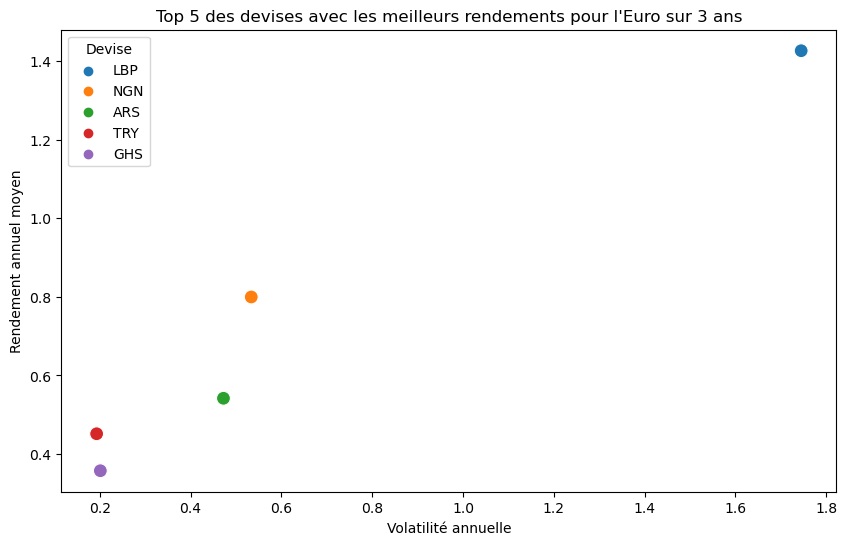

Top 5 des devises avec les meilleurs rendements pour l'Euro sur 5 ans :
          Rendement Annuel Moyen  Volatilité Annuelle
currency                                             
LBP                     0.900972             1.384615
NGN                     0.799547             0.533698
ARS                     0.438819             0.383510
ZMW                     0.305801             0.159368
TRY                     0.305282             0.170985




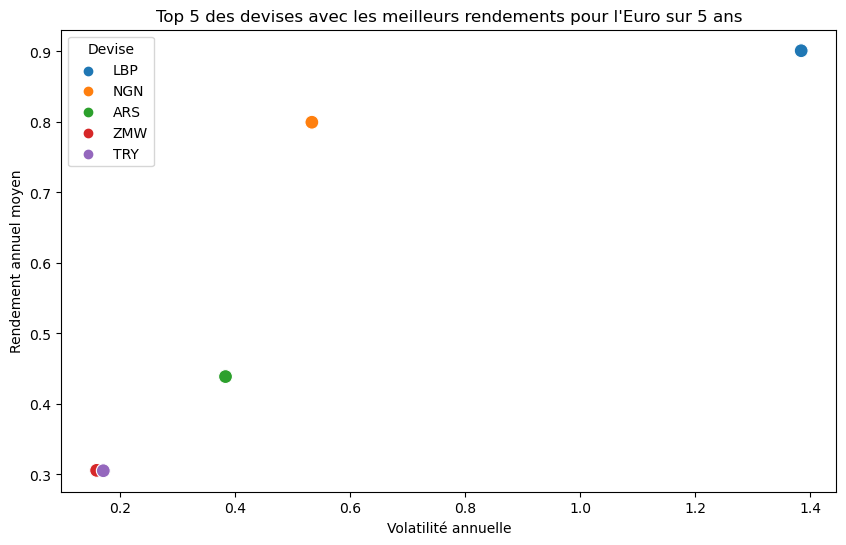

In [25]:
# Affichage des résultats
for period_name, performance in top_performances.items():
    print(f"Top 5 des devises avec les meilleurs rendements pour l'Euro sur {period_name} :")
    print(performance)
    print("\n")

    # Visualisation des performances
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=performance, x='Volatilité Annuelle', y='Rendement Annuel Moyen', hue=performance.index, s=100)
    plt.title(f"Top 5 des devises avec les meilleurs rendements pour l'Euro sur {period_name}")
    plt.xlabel('Volatilité annuelle')
    plt.ylabel('Rendement annuel moyen')
    plt.legend(title='Devise')
    plt.show()

Les graphiques présentés offrent une vue complémentaire en segmentant les devises en catégories de risque et de rendement, ce qui aide à mieux comprendre le paysage d'investissement. En combinant ces informations, les investisseurs peuvent élaborer des stratégies plus équilibrées, en tirant parti à la fois des opportunités de haut rendement et en minimisant les risques à travers des investissements plus stables (diversification de portefeuille pour mesurer son exposition aux risques)

### Analyse par paires.

1. LBP (Livre Libanaise) : Offre des rendements extrêmement élevés sur toutes les périodes analysées (1 an, 3 ans, 5 ans).
La volatilité est également très élevée, ce qui indique une instabilité significative. Cela est probablement dû à la situation économique et politique instable du Liban.

2. NGN (Naira Nigérian) : Montre un rendement élevé et stable sur toutes les périodes avec une volatilité modérée.
Le NGN apparaît comme une option attractive pour les investisseurs cherchant un bon compromis entre rendement et risque.

3. ARS (Peso Argentin) : Offre des rendements élevés avec une volatilité modérée. La stabilité relative du rendement et de la volatilité sur toutes les périodes en fait une option viable pour les investisseurs tolérants au risque.

4. CLF (Unidad de Fomento Chilienne) et MWK (Kwacha Malawite) : Apparaissent uniquement dans le top 5 sur 1 an avec des rendements et des volatilités modérés. Indiquent des options moins risquées à court terme.

5. TRY (Livre Turque) et ZMW (Kwacha Zambien) : Montrent des rendements modérés avec une volatilité faible sur les périodes de 3 et 5 ans. Ces devises apparaissent comme des options stables à moyen et long terme.

### Analyse par volatilité et rendement

* Volatilité et Rendement : Les devises comme la Livre Libanaise (LBP), le Naira Nigérian (NGN), et le Peso Argentin (ARS) se distinguent par des rendements plus élevés sur les périodes de 1, 3, et 5 ans. Cependant, elles affichent également une volatilité modérée ou élevée (LBP), illustrant le principe de base de l'investissement : un potentiel de rendement élevé est souvent associé à un risque plus élevé. 

* Stabilité et Sécurité : D'autre part, des devises comme la Livre Turque (TRY) et le Kwacha Zambien (ZMW) montrent une volatilité plus faible avec des rendements modérés. Ces devises représentent des options d'investissement plus stables, adaptées aux investisseurs qui privilégient la préservation du capital et une approche plus conservatrice.

# Analyse segmentée

Ces analyses auront lieu dans des notebooks séparées avec entrainement de plusieurs modèles.

## Sélection des devises

Suite à notre analyse globale mesurant la volatilité et le rendement, nous allons maintenant sélectionner une devise selon ses trois catégories pour mesurer les différentes tendances et identifier si un modèle est meilleur qu'un autre dans une catégorie plutôt qu'une autre.

**Haute volatilité et haut rendement : Livre Libanaise (LBP)**
* Malgré sa volatilité extrême, la LBP a montré le potentiel de rendements très élevés. Pour les investisseurs prêts à accepter un risque élevé, elle offre la possibilité de gains significatifs.

**Rendements équilibrés pour des risques modérés : le Naira Nigérian (NGN)** 
* La NGN offre un bon équilibre entre rendement et risque. Sa volatilité n'est ni trop élevée ni trop basse, ce qui en fait un bon compromis pour stabiliser le portefeuille tout en bénéficiant de rendements intéressants.

**Rendements mesurés et stabilité : Livre Turque (TRY)** 
* Le TRY présente une faible volatilité, ce qui en fait une option sûre pour protéger le portefeuille contre les perturbations du marché. En tant que telle, elle peut servir de contrepoids aux devises plus risquées.

Pour des raisons de simplicité et de lisibilité, nous analyserons chaque devise dans des notebooks séparés et nous identifierons le modèle réalisant les meilleures prédictions selon la "tendance" de la devise.

